In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from scipy.optimize import minimize
import os
import cma
import glob

matplotlib.rcParams.update({'font.size': 17})
matplotlib.rcParams['figure.figsize'] = [15, 15]

# studied animal

animal = "Panthera leo"

# Path to where the data for that animal is stored
data_path = glob.glob("./mortality_data/animals_and_plants/animals_for_parameters/"+'*/*'+animal+'*'+".csv")[0]

# function computing the contribution of aging to the hazard rate
@np.vectorize
def aging_gompertz_makaham(x, a, b, c):
    return c + a*np.exp((b*x))

# function computing the contribution of learning to the hazard rate
@np.vectorize
def learning(x, Lmax, k_learning, n):
    return (Lmax/(1 + np.exp(n*(x-k_learning)))) - Lmax

# function computing the contribution of growth to the hazard rate
@np.vectorize
def growth(x, Gmax, growth_speed, age_stop):
    results = []
    if (x < age_stop):
        results.append(Gmax/(1 + x**growth_speed) - Gmax ) 
    else : 
        results.append(Gmax/(1 + age_stop**growth_speed) - Gmax ) 
    return np.array(results)

# function summing all the contributions and returning the log of this sum. 
@np.vectorize
def log_mortality_gompertz_makaham(x, a, b, c, Lmax, k_learning, n, Gmax, growth_speed, age_stop):
    res = aging_gompertz_makaham(x, a, b, c) + learning(x, Lmax, k_learning, n) + growth(x, Gmax, growth_speed, age_stop)
    if res > 0 : 
        return np.log10(res)
    else :
        return np.log10(1.)

# cost function used for fitting
def errlearning_gompertz_makaham(params, x, y, weights, lm=0, ord=0):
    from numpy.linalg import norm
    a, b, c, Lmax, k_learning, n, Gmax, growth_speed, age_stop = params

    # penalization for negative values
    if any(e<0 for e in params) == True:
        return 100

    err = norm(weights*(log_mortality_gompertz_makaham(x, a, b, c, Lmax, k_learning, n, Gmax, growth_speed, age_stop) - y))
    return err + lm * norm(params, ord)

# cost function used for fitting with CMA
def errlearning_gompertz_makaham_cma(params, x, y, weights, bounds, lm=0, ord=0):
    from numpy.linalg import norm
    a, b, c, Lmax, k_learning, n, Gmax, growth_speed, age_stop = params

    penality = 0
    #checks if params are in bound
    for i in range(len(params)):
        if params[i] > bounds[i][1] : 
            penality += (params[i] - bounds[i][1])**2
        if params[i] < bounds[i][0]:
            penality += (1 + bounds[i][0] - params[i])**2


    err = norm(weights*(log_mortality_gompertz_makaham(x, a, b, c, Lmax, k_learning, n, Gmax, growth_speed, age_stop) - y))
    return err + lm * norm(params, ord) + penality

# function used for computing the s measure (average distance between the data and the fitted model in %)
def s_measure(pred, data):
    distance = np.absolute(pred - data)
    distance_percentage = (distance/np.absolute(data))*100
    return np.mean(distance_percentage)
    # return np.average(distance_percentage, weights=weights)


# fitting function using the minimize method from scipy
def fit(x, mortality_array, guess, bounds):

    # weight computation, can sometimes improve the fit but may also impact it negatively
    lx = [10000]
    for i in range(1, mortality_array.shape[0]):
        lx.append(lx[i-1]-lx[i-1]*mortality_array[i])
    lx = np.array(lx)
    surviving_fraction = lx/lx[0]
    surviving_fraction = np.square(surviving_fraction)

    # comment this line to use the computed weights
    surviving_fraction = np.ones_like(surviving_fraction)

    params = minimize(errlearning_gompertz_makaham, guess, method="SLSQP", tol = 1e-15, args=(x, np.log10(mortality_array), surviving_fraction, 0, 0), bounds = bounds)
    return params.x

# fitting function using the CMA method, more accurate but slower than the one using minimize from scipy
def fit_cma(x, mortality_array, sigma, bounds):
    lx = [10000]
    for i in range(1, mortality_array.shape[0]):
        lx.append(lx[i-1]-lx[i-1]*mortality_array[i])
    lx = np.array(lx)
    surviving_fraction = lx/lx[0]
    surviving_fraction = np.square(surviving_fraction)
    surviving_fraction = np.ones_like(surviving_fraction)
    global f 
    def f(params):
        return errlearning_gompertz_makaham_cma(params, x, np.log10(mortality_array), surviving_fraction,  bounds)

    es = cma.CMAEvolutionStrategy([4.76614499e-03, 2.29715390e-02, 1.87466206e-02, 5.58711082e-03, 3.63829644e+01, 1.38484469e-01, 4.34710796e-02, 0.1, 30], sigma)
    es.optimize(f, iterations=5000, n_jobs=-1)
    return es

In [7]:
# read text file into pandas DataFrame
base_dataframe = pd.read_csv(data_path, sep=",")
base_dataframe = base_dataframe[['x', 'qx']]
df1 = base_dataframe.astype(float)

years = df1[['x']].to_numpy().squeeze()
mortality_array = df1[['qx']].to_numpy().squeeze()

beg = np.min(years) #starting x 
fin = np.max(years) #final x
steps = years.size
x = np.linspace(beg, fin, steps)

# guess and bounds for the fit
guess = [4.17399393e-03, 4.29746495e-02, 2.86076474e-02, 3.91364426e-02, 4.61448543e+01, 8.85350563e-02, 5.92916574e-02, 0.1, 30]
bounds = ((0,1),(0,1),(0,1),(0,1),(0,fin),(0,3),(0,1),(0, 1),(0, fin))

# fit with CMA
es = fit_cma(x, mortality_array, 0.05, bounds)

params_cma = es.result.xfavorite

# fit with scipy.minimize
params_scipy = fit(x, mortality_array, guess, bounds)

pred_cma = log_mortality_gompertz_makaham(x, params_cma[0], params_cma[1], params_cma[2],  params_cma[3], params_cma[4], params_cma[5], params_cma[6], params_cma[7], params_cma[8])

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=702756, Thu Oct 13 09:56:35 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 5.468447919748864e+02 1.0e+00 4.60e-02  4e-02  5e-02 0:00.0
    2     20 5.434719462602976e+02 1.1e+00 4.62e-02  4e-02  5e-02 0:00.0
    3     30 5.374712465904292e+02 1.3e+00 5.08e-02  5e-02  5e-02 0:00.0


/tmp/ipykernel_3182928/2606984968.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  results.append(Gmax/(1 + x**growth_speed) - Gmax )
/tmp/ipykernel_3182928/2606984968.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  results.append(Gmax/(1 + x**growth_speed) - Gmax )
/tmp/ipykernel_3182928/2606984968.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  results.append(Gmax/(1 + x**growth_speed) - Gmax )
/tmp/ipykernel_3182928/2606984968.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  results.append(Gmax/(1 + x**growth_speed) - Gmax )
/tmp/ipykernel_3182928/2606984968.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  results.append(Gmax/(1 + x**growth_speed) - Gmax )
/tmp/ipykernel_3182928/2606984968.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  results.append(Gmax/(1 + x**growth_speed) - Gmax )
/tmp/ipykernel_3182928/2606984968.py:32: RuntimeWarning: divide by zer

  100   1000 9.161104210754402e-01 7.4e+00 5.93e-02  2e-02  5e-02 0:01.1
  200   2000 2.717583105996789e-01 1.7e+02 2.20e-02  2e-03  3e-02 0:01.9
  300   3000 2.641345208017363e-01 4.8e+02 2.94e-02  1e-03  4e-02 0:02.8
  400   4000 2.574978400012942e-01 1.4e+03 9.19e-02  1e-03  1e-01 0:03.7
  500   5000 2.567031220950717e-01 1.0e+03 2.90e-02  2e-04  1e-02 0:04.6
  600   6000 2.564963975908569e-01 1.1e+03 6.34e-02  2e-04  1e-02 0:05.6
  700   7000 2.564284916931737e-01 8.2e+02 7.49e-02  2e-04  6e-03 0:06.6
  800   8000 2.564080051117362e-01 1.5e+03 6.14e-02  8e-05  3e-03 0:07.5
  900   9000 2.564040841842202e-01 1.4e+03 4.82e-02  6e-05  1e-03 0:08.4
 1000  10000 2.564039917422797e-01 2.8e+03 2.41e-03  4e-07  4e-05 0:09.4
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1057  10570 2.564039916524546e-01 3.3e+03 3.31e-04  5e-09  5e-06 0:09.9


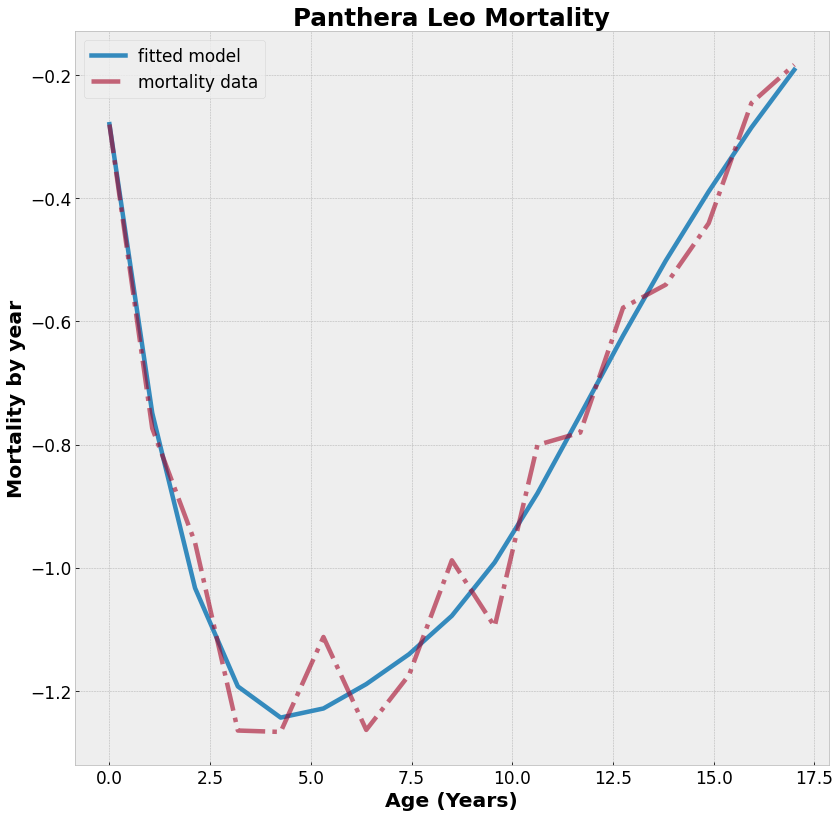

In [8]:
# plot of the CMA fit
with plt.style.context("bmh"):
    fig, ax = plt.subplots()
    fig.set_size_inches(13.5, 13.5)
    ax.plot(x, pred_cma, linewidth=4.5)

    x_label = "Age " + "("+os.path.splitext(os.path.basename(data_path))[0].split(' ')[-1]+")"
    ax.set_xlabel(x_label, fontweight="bold")
    ax.set_ylabel("Mortality by year", fontweight="bold")
    ax.plot(x, np.log10(mortality_array), '-.', alpha=0.6, linewidth=4.5)
    title = animal.title() + " Mortality"
    ax.set_title(title, fontweight="bold")
    ax.legend(["fitted model", "mortality data"])
    fig.show()
    path = "/home/spsalmon/images_for_paper/"+animal+"_fit.png"
    # fig.savefig(path, dpi=300)

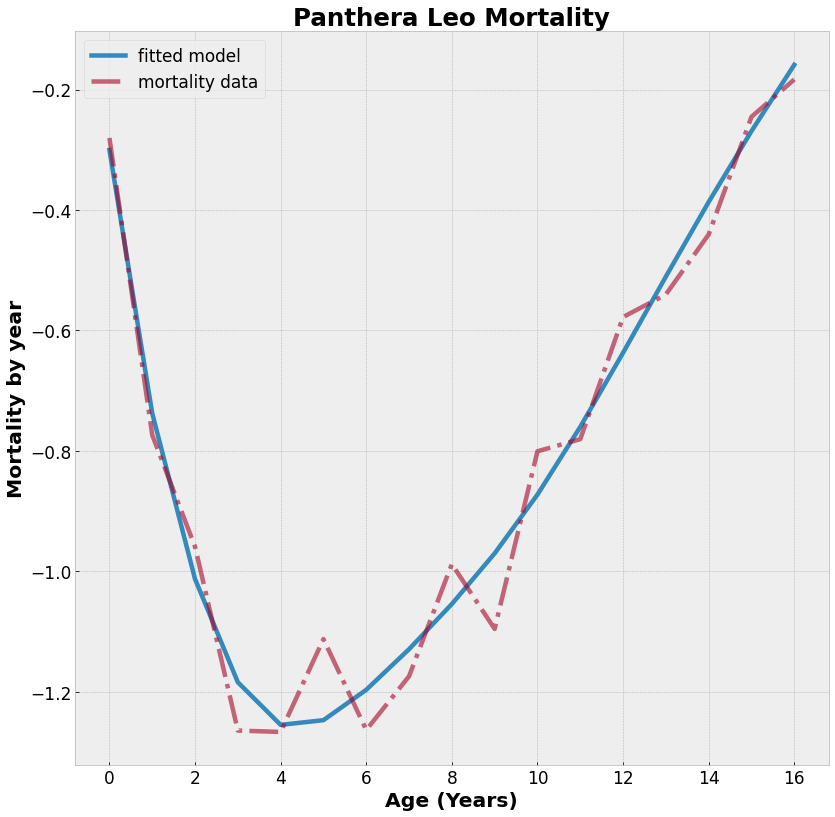

In [9]:
pred_scipy = log_mortality_gompertz_makaham(x, params_scipy[0], params_scipy[1], params_scipy[2],  params_scipy[3], params_scipy[4], params_scipy[5], params_scipy[6], params_scipy[7], params_scipy[8])

# plot of the scipy fit
with plt.style.context("bmh"):
    fig, ax = plt.subplots()
    fig.set_size_inches(13.5, 13.5)
    ax.plot(pred_scipy, linewidth=4.5)

    x_label = "Age " + "("+os.path.splitext(os.path.basename(data_path))[0].split(' ')[-1]+")"
    ax.set_xlabel(x_label, fontweight="bold")
    
    ax.set_ylabel("Mortality by year", fontweight="bold")
    ax.plot(np.log10(mortality_array), '-.', alpha=0.6, linewidth=4.5)
    title = animal.title() + " Mortality"
    ax.set_title(title, fontweight="bold")
    ax.legend(["fitted model", "mortality data"])
    fig.show()
    path = "/home/spsalmon/images_for_paper/"+animal+"_fit.png"
    # fig.savefig(path, dpi=300)

In [10]:
# Comparison between scipy.minize and CMA

print("s_measure of the CMA fit :", s_measure(pred_cma, np.log10(mortality_array)))
print("s_measure of the scipy.minimize fit :", s_measure(pred_scipy, np.log10(mortality_array)))

s_measure of the CMA fit : 6.906948335264607
s_measure of the scipy.minimize fit : 7.450216992648061
